## Objective
Plot model's performance (recall, precision, f1_score) as function of location probability threshold

In [3]:
%load_ext autoreload
%autoreload

# Update PATH to allow imports
import sys
sys.path.append("/data/MEAprojects/DLSpikeSorter")

# Imports
from src.model import ModelSpikeSorter
from src.data import RecordingCrossVal
from src.utils import random_seed
from src.plot import set_dpi
import numpy as np
import torch
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load model
MODEL_PATH = "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2954/230101_134042_729459"
##
model = ModelSpikeSorter.load(MODEL_PATH).eval().to(torch.float16)

In [14]:
# Load recording data
REC = "2954"
##
rec_cross_val = RecordingCrossVal(sample_size=model.sample_size, front_buffer=model.buffer_front_sample, end_buffer=model.buffer_end_sample,
                                  num_wfs_probs=[0.6, 0.24, 0.12, 0.04], isi_wf_min=5, isi_wf_max=None,
                                  samples_per_waveform=(2, 40),
                                  thresh_amp=3, thresh_std=0.6,
                                  dtype=torch.float16,
                                  mmap_mode="r", device="cuda")
_, _, val = rec_cross_val[REC]

In [15]:
random_seed(231)
##
# Get model inputs and outputs on data
inputs_list = []
outputs_list = []
with torch.no_grad():
    for inputs, num_wfs, wf_locs, wf_alphas in val:
        inputs_list.append((inputs, num_wfs, wf_locs, wf_alphas))
        outputs_list.append(model(inputs))

Using random seed 231


In [16]:
# Get performance based on location probability threshold
START = 2.5
STOP = 97.5
STEP = 2.5
##
# Find model's performance
threshes = []
recalls = []
precisions = []
f1_scores = []
num = int(STOP // STEP)
for thresh in np.linspace(START, num * STEP, num):
    model.set_loc_prob_thresh(thresh)

    perf = model.perf(inputs_list, outputs_list=outputs_list)

    threshes.append(thresh)
    recalls.append(perf[3])
    precisions.append(perf[4])
    f1_scores.append(perf[5])
    model.perf_report(f"Prob Thresh: {thresh:.1f}%", perf)

Prob Thresh: 2.5%: Loss: 0.740 | WF Detected: 130.1% | Accuracy: 99.8% | Recall: 98.6% | Precision: 75.8% | F1 Score: 85.7% | Loc MAD: 0.17 frames = 0.0084 ms
Prob Thresh: 5.0%: Loss: 0.740 | WF Detected: 118.4% | Accuracy: 99.9% | Recall: 98.1% | Precision: 82.8% | F1 Score: 89.8% | Loc MAD: 0.17 frames = 0.0085 ms
Prob Thresh: 7.5%: Loss: 0.740 | WF Detected: 112.3% | Accuracy: 99.9% | Recall: 97.3% | Precision: 86.7% | F1 Score: 91.7% | Loc MAD: 0.18 frames = 0.0088 ms
Prob Thresh: 10.0%: Loss: 0.740 | WF Detected: 108.4% | Accuracy: 99.9% | Recall: 96.9% | Precision: 89.4% | F1 Score: 93.0% | Loc MAD: 0.19 frames = 0.0095 ms
Prob Thresh: 12.5%: Loss: 0.740 | WF Detected: 105.7% | Accuracy: 99.9% | Recall: 96.2% | Precision: 91.1% | F1 Score: 93.6% | Loc MAD: 0.19 frames = 0.0094 ms
Prob Thresh: 15.0%: Loss: 0.740 | WF Detected: 103.6% | Accuracy: 99.9% | Recall: 95.8% | Precision: 92.4% | F1 Score: 94.1% | Loc MAD: 0.19 frames = 0.0094 ms
Prob Thresh: 17.5%: Loss: 0.740 | WF Detect

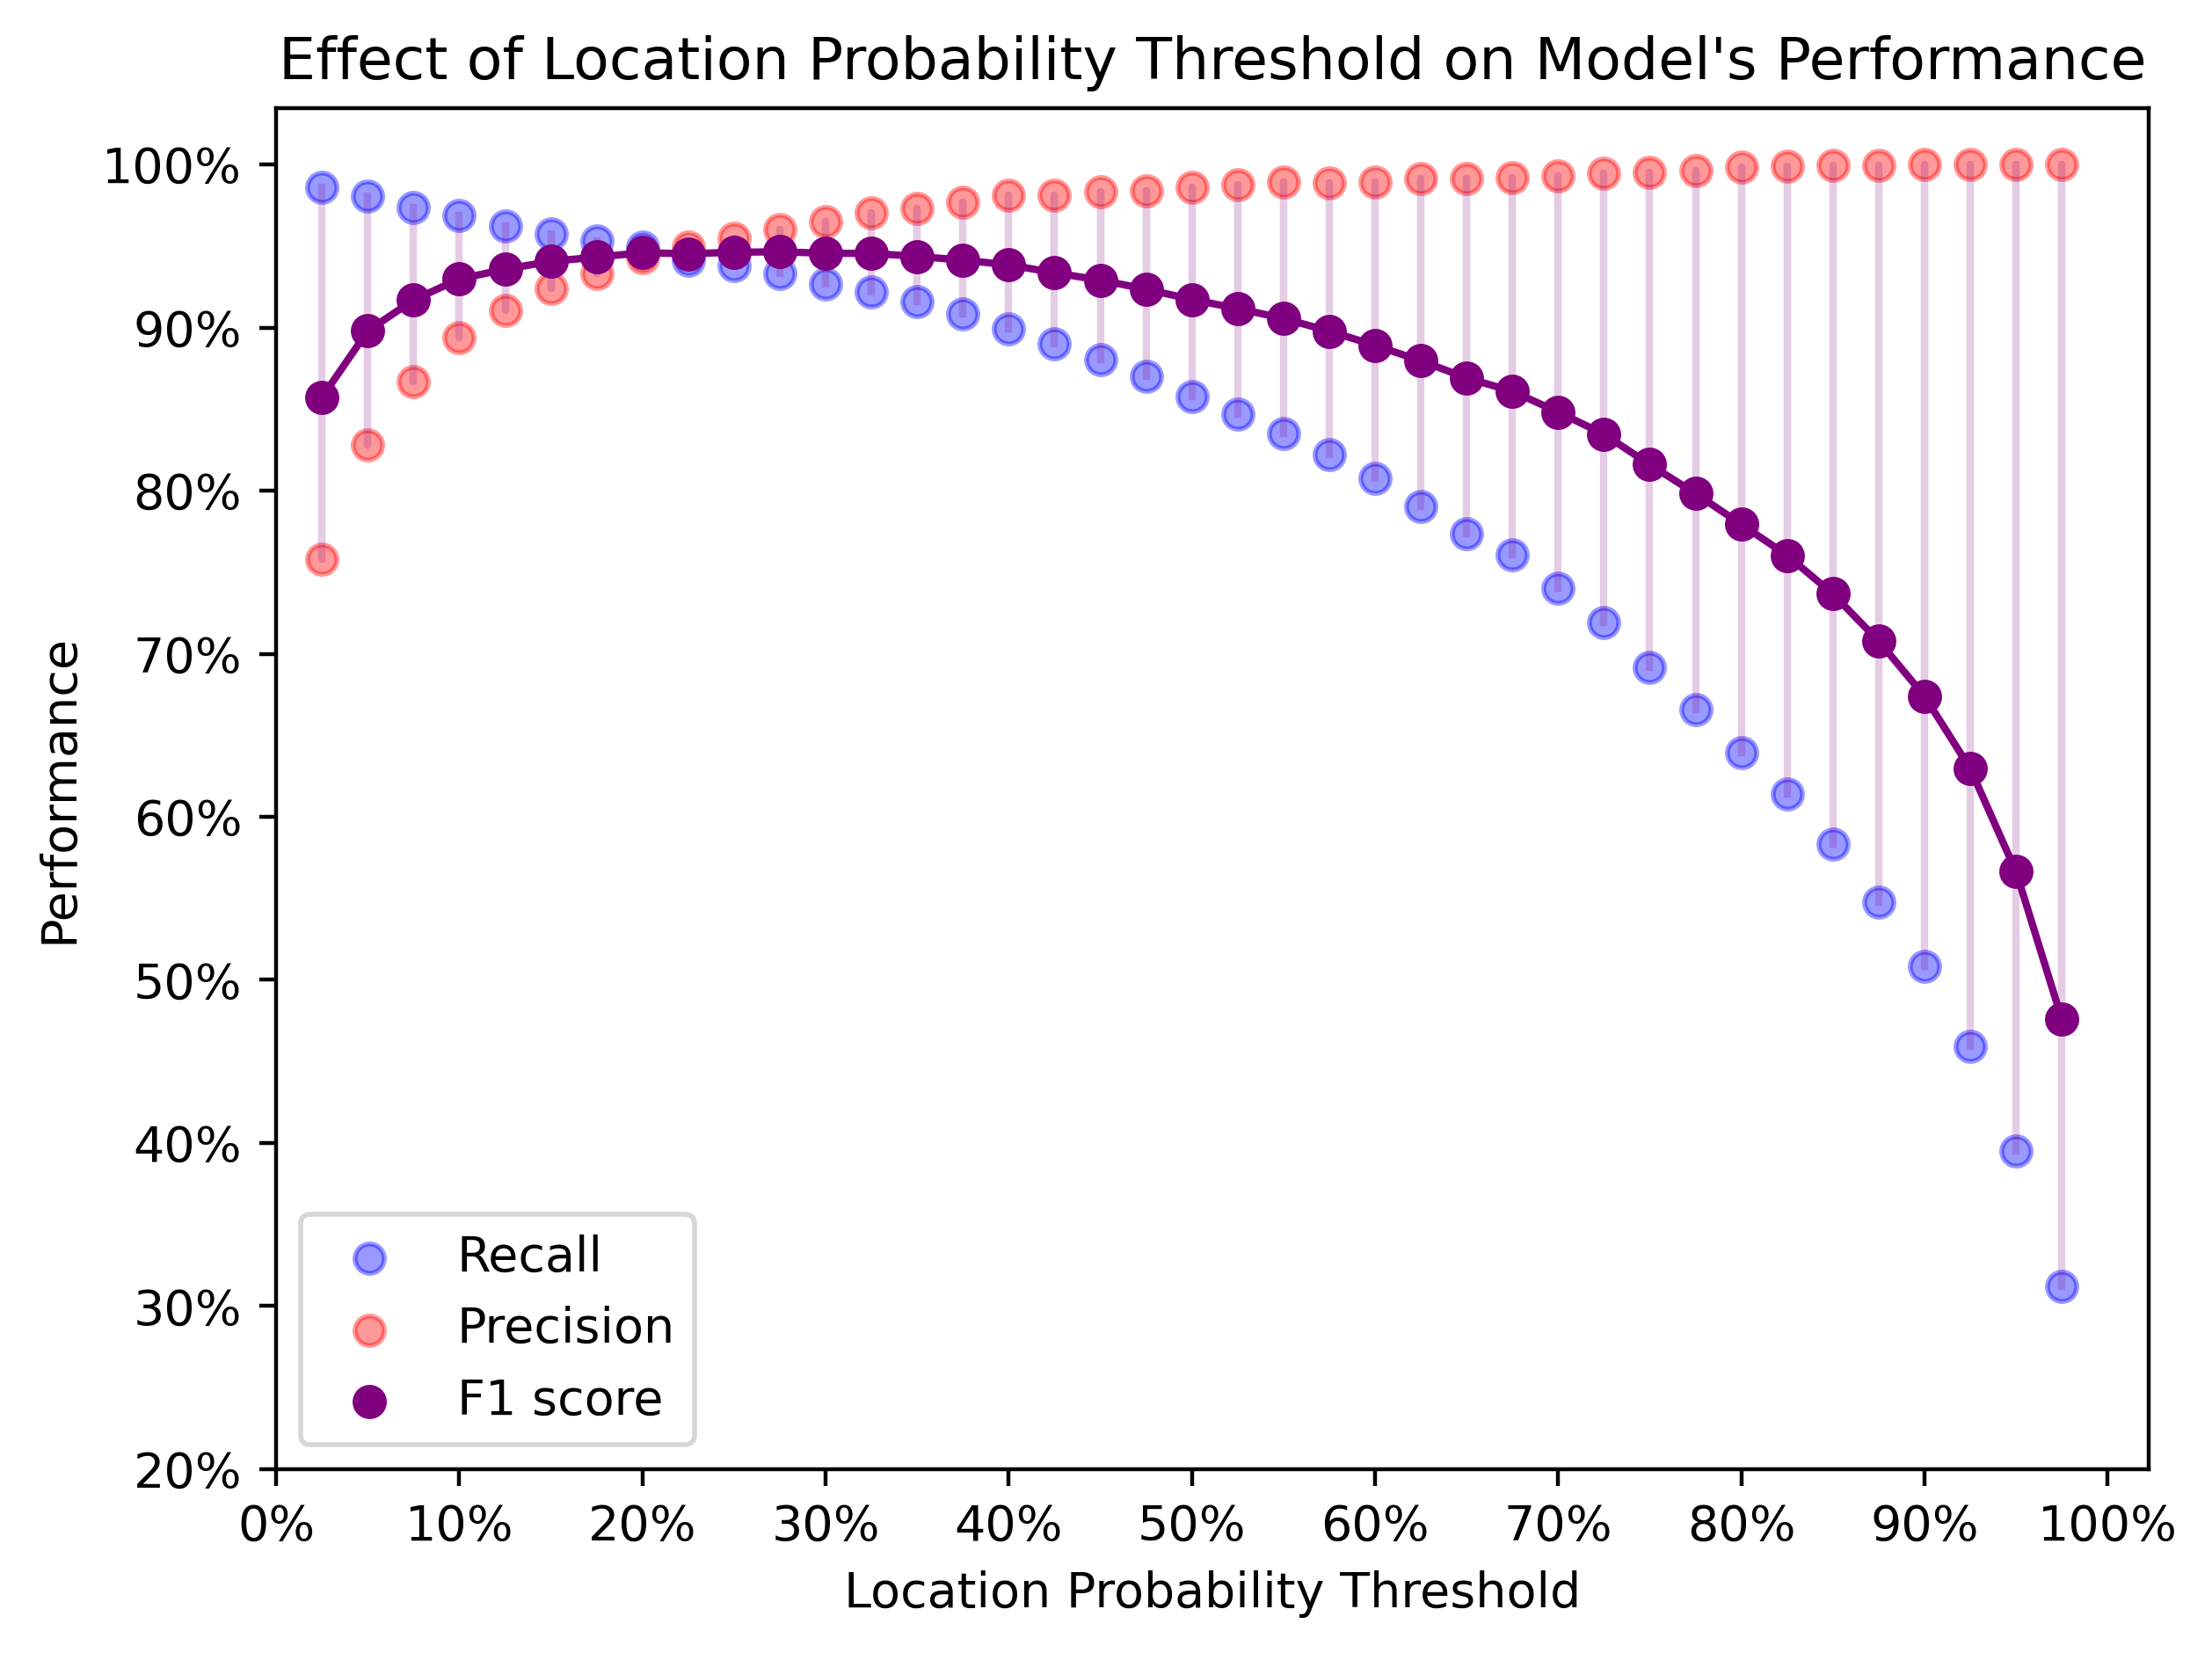

In [25]:
set_dpi(400)
##
# Plot performance
plt.title("Effect of Location Probability Threshold on Model's Performance")
plt.xlabel("Location Probability Threshold")
plt.ylabel("Performance")

for i, (thresh, recall, precision, f1) in enumerate(zip(threshes, recalls, precisions, f1_scores)):
    # Plot points
    plt.scatter(thresh, recall, c="blue", alpha=0.4, label="Recall" if i==0 else None)
    plt.scatter(thresh, precision, c="red", alpha=0.4, label="Precision" if i==0 else None)
    plt.scatter(thresh, f1, c="purple", label="F1 score" if i==0 else None)

    # Plot vertical line to connect points
    plt.plot([thresh]*3, [recall, precision, f1], c="purple", alpha=0.2)

# Plot line through all points
plt.plot(threshes, f1_scores, c="purple")

plt.xlim(0)
yticks = [20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.yticks(yticks, [str(x)+"%" for x in yticks])
plt.ylim(20)
xticks = range(0, 101, 10)
plt.xticks(xticks, [str(x)+"%" for x in xticks])
plt.legend()
plt.tight_layout()
plt.show()